# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [ ]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn
!pip3 install cufflinks
!pip3 install pmdarima
!pip3 install chart-studio

In [20]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
import statsmodels.graphics.tsaplots as tsaplots
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

## Influx Setting

In [21]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

### Influx Queries

[<FluxTable: 12 columns, 483 records>, <FluxTable: 12 columns, 754 records>]
[<FluxTable: 12 columns, 483 records>, <FluxTable: 12 columns, 754 records>]
[<FluxTable: 12 columns, 483 records>]


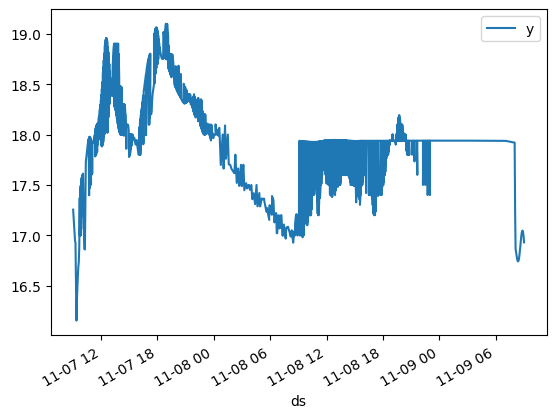

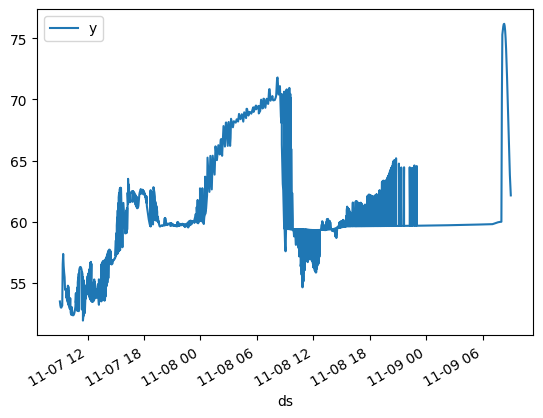

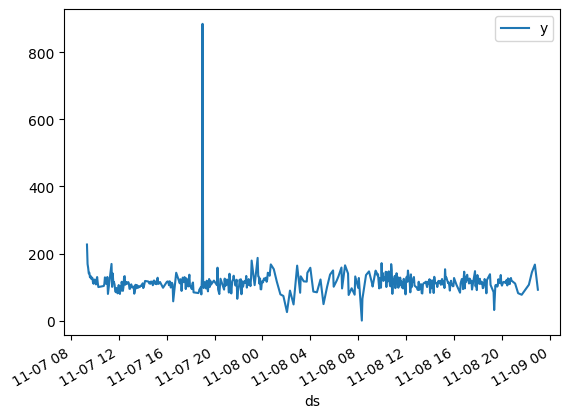

In [44]:
from pandas import DataFrame


def result_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)
    
buckets = ['temperature', 'humidity', 'gas']
dfTemp = DataFrame
dfHum = DataFrame
dfGas = DataFrame

for bucket in buckets:
    query = 'from(bucket: "' + bucket + '")' \
                ' |> range(start: 2022-11-07T09:00:00.00Z, stop: 2022-11-09T09:00:00.00Z)' \
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "'+ bucket + '")' \
                ' |> aggregateWindow(every: 3m, fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    print(result)
    # Convert the results to dataframe
    if (bucket == "temperature" and  result):
        dfTemp = result_to_dataframe(result)
        dfTemp['ds'] = dfTemp['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfTemp[plot_cols]
        plot_features.index = dfTemp['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "humidity" and result):
        dfHum = result_to_dataframe(result)
        dfHum['ds'] = dfHum['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfHum[plot_cols]
        plot_features.index = dfHum['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "gas" and result):
        dfGas = result_to_dataframe(result)
        dfGas['ds'] = dfGas['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfGas[plot_cols]
        plot_features.index = dfGas['ds']
        _ = plot_features.plot(subplots=True)

### Informations about DataFrames. Train and Test Datasets cretion 

In [45]:
trainTemp = DataFrame
testTemp = DataFrame
trainHum= DataFrame
testHum = DataFrame
trainGas = DataFrame
testGas = DataFrame
global tempDate
global humDate
global gasDate

if ( not dfTemp.empty):
    print("Temperature Dataset")    
    print(dfTemp.describe().transpose())
    nrows = (len(dfTemp.values))
    splitPoint = int (nrows * 0.60)
    trainTemp = dfTemp['y'] [:splitPoint]
    testTemp = dfTemp ['y'] [splitPoint:]
    tempDate = dfTemp ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    tempDate['ds'] = tempDate.ds.dt.floor('min')

if (not dfHum.empty):
    print("Humidity Dataset")
    print(dfHum.describe().transpose())
    nrows = (len(dfHum.values))
    splitPoint = int (nrows * 0.60)
    trainHum = dfHum['y'] [:splitPoint]
    testHum = dfHum ['y'] [splitPoint:]
    humDate = dfHum ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')   

if (not dfGas.empty):
    print("Gas Dataset")
    print(dfGas.describe().transpose())
    nrows = (len(dfGas.values))
    splitPoint = int (nrows * 0.60)
    trainGas = dfGas['y'] [:splitPoint]
    testGas = dfGas ['y'] [splitPoint:]
    gasDate = dfGas ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')

Temperature Dataset
    count       mean       std        min        25%        50%        75%  \
y  1237.0  17.918935  0.450137  16.155556  17.777195  17.938629  18.052778   

         max  
y  19.097222  
Humidity Dataset
    count       mean       std        min        25%        50%        75%  \
y  1237.0  59.997536  3.736029  51.916364  59.349871  59.685106  60.447421   

         max  
y  76.176009  
Gas Dataset
   count        mean        std  min         25%         50%         75%  \
y  483.0  114.395033  40.873204  0.0  102.159722  112.583333  123.041667   

          max  
y  885.068966  


### Check if the time-series are stationary using the Dickey-Fuller test

In [46]:
from statsmodels.tsa.stattools import adfuller

resultTemp = 0.0
resultHum = 0.0
resultGas = 0.0

if (not dfTemp.empty):
    resultTemp = adfuller(trainTemp)
    print('TEMPERATURE: ADF Statistic: %f' % resultTemp[0])
    print('TEMPERATURE: p-value: %f' % resultTemp[1])

if (not dfHum.empty):
    resultHum = adfuller(trainHum)
    print('HUMIDITY: ADF Statistic: %f' % resultHum[0])
    print('HUMIDITY: p-value: %f' % resultHum[1])

if (not dfGas.empty):
    resultGas = adfuller(trainGas)
    print('GAS: ADF Statistic: %f' % resultGas[0])
    print('GAS: p-value: %f' % resultGas[1])
    

TEMPERATURE: ADF Statistic: -2.646216
TEMPERATURE: p-value: 0.083817
HUMIDITY: ADF Statistic: -2.037431
HUMIDITY: p-value: 0.270406
GAS: ADF Statistic: -16.037594
GAS: p-value: 0.000000


### If P Value > 0.05 we go ahead with finding the order of differencing.

TEMPERATURE: ADF Statistic: -6.527069
TEMPERATURE: new p-value: 0.000000


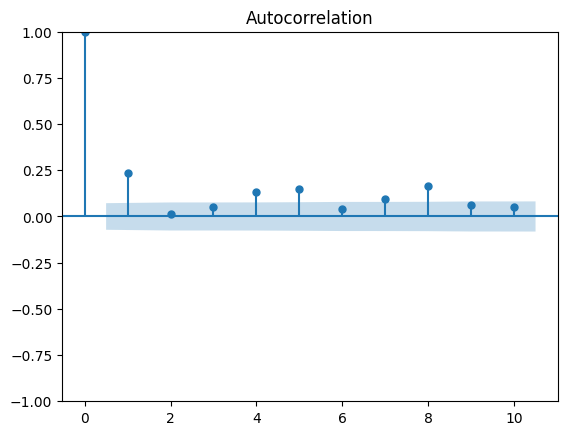

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



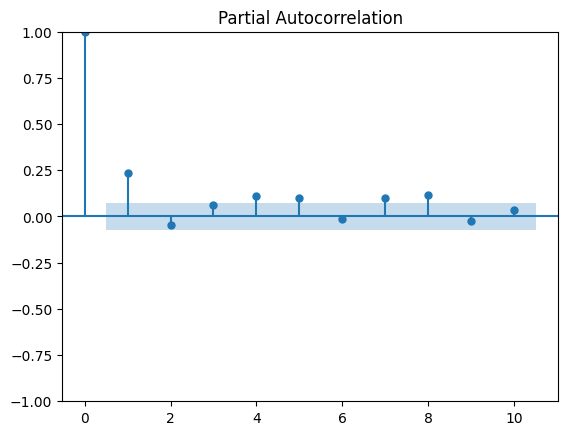

HUMIDITY: ADF Statistic: -15.495105
HUMIDITY: new p-value: 0.000000


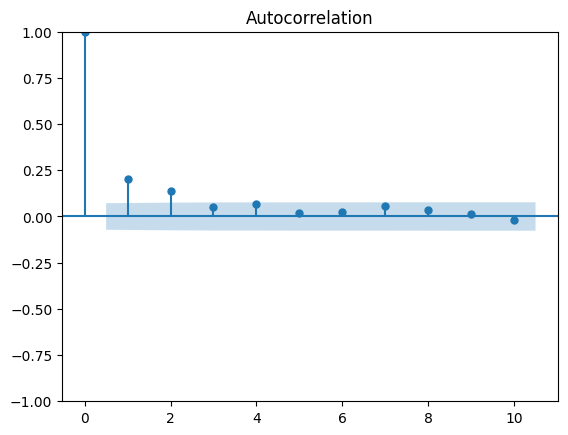

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



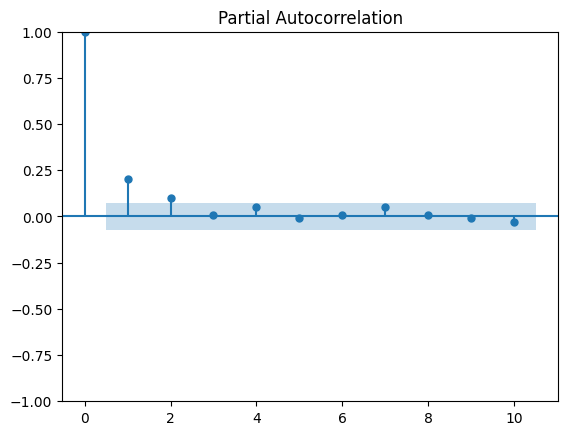

GAS: ADF Statistic: -7.590199
GAS: new p-value: 0.000000


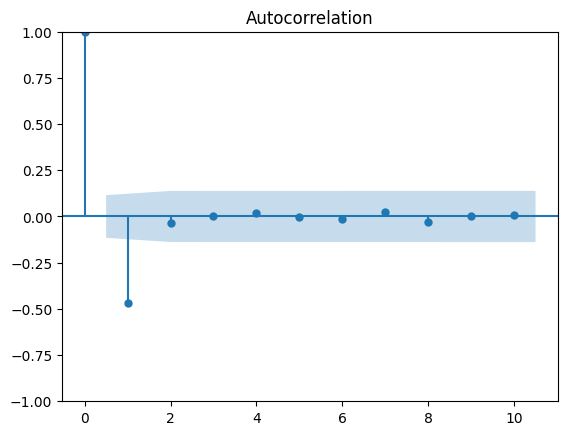

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



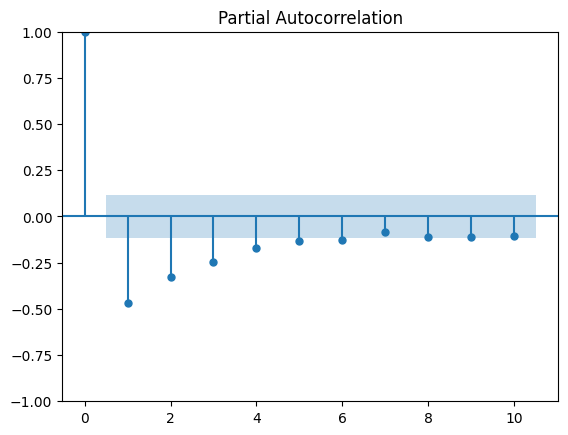

In [59]:
from statsmodels.graphics import tsaplots

if (not dfTemp.empty):
    aux = trainTemp
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('TEMPERATURE: ADF Statistic: %f' % result[0])
    print('TEMPERATURE: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfHum.empty):
    aux = trainHum
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('HUMIDITY: ADF Statistic: %f' % result[0])
    print('HUMIDITY: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfGas.empty):
    aux = trainGas
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('GAS: ADF Statistic: %f' % result[0])
    print('GAS: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

### Apply ARIMA model to all Datasets

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error
#ARIMA(p,d,q)

global temp_model_fit
global hum_model_fit
global gas_model_fit

if (not trainTemp.empty):
  historyTemp = [x for x in trainTemp]
  predictionsTemp = list()
if (not trainHum.empty):
  historyHum = [x for x in trainHum]
  predictionsHum = list()
if (not trainGas.empty):
  historyGas= [x for x in trainGas]
  predictionsGas = list()

if (not dfTemp.empty):
  for t in testTemp.index:
    model = ARIMA(historyTemp, order=(0,1,0))
    temp_model_fit = model.fit()
    output = temp_model_fit.forecast()
    yest = output[0]
    predictionsTemp.append(yest)
    obs= testTemp[t]
    historyTemp.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfHum.empty):
  for t in testHum.index:
    model = ARIMA(historyHum, order=(1,1,1))
    hum_model_fit = model.fit()
    output = hum_model_fit.forecast()
    yest = output[0]
    predictionsHum.append(yest)
    obs= testHum[t]
    historyHum.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfGas.empty):
  for t in testGas.index:
    model = ARIMA(historyGas, order=(0,1,0))
    gas_model_fit = model.fit()
    output = gas_model_fit.forecast()
    yest = output[0]
    predictionsGas.append(yest)
    obs= testGas[t]
    historyGas.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))


In [57]:
def send_predictions(df, date, bucket):
	lines = [str(df['y'][d]) for d in range(len(df))]
	if(bucket == "gas"):
		lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " gasPred" + '=' + str(df['y'][d])
										+ ' ' + str(int(time.mktime(date['ds'][d].timetuple()))) + "000000000" for d in range(len(date))]
	else:
		lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(df['y'][d])
										+ ' ' + str(int(time.mktime(date['ds'][d].timetuple()))) + "000000000" for d in range(len(date))]
	write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
															jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
	write_client.write(bucket, INFLUXDB_ORG, lines)

### ARIMA model evaluation (RMSE)

Test RMSE: 0.055


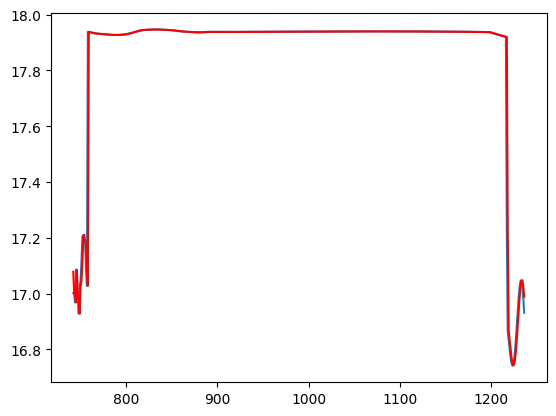

Test RMSE: 0.563


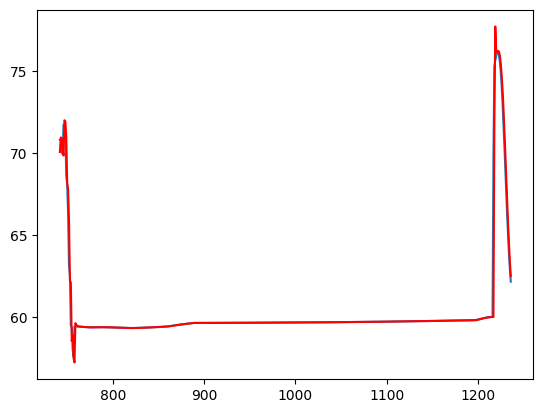

Test RMSE: 22.954


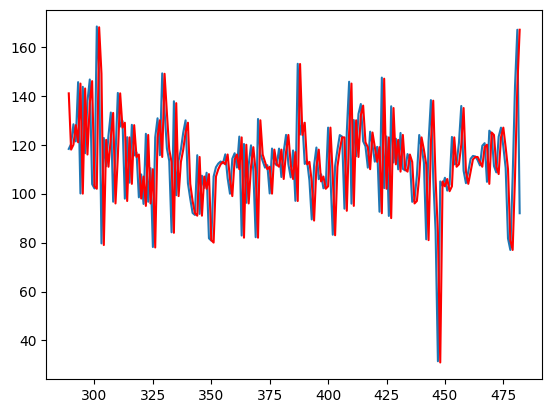

In [64]:
if (not trainTemp.empty):
  rmse = math.sqrt(mean_squared_error(testTemp, predictionsTemp))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsTemp)
  df.columns = ['y']
  send_predictions(df, tempDate, "temperature")
  df.set_index(testTemp.index, inplace=True)
  plt.plot(testTemp)
  plt.plot(df, color='red')
  plt.show()

if (not trainHum.empty):
  rmse = math.sqrt(mean_squared_error(testHum, predictionsHum))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsHum)
  df.columns = ['y']
  send_predictions(df, humDate, "humidity")
  df.set_index(testHum.index, inplace=True)
  plt.plot(testHum)
  plt.plot(df, color='red')
  plt.show()
  
if (not trainGas.empty):
  rmse = math.sqrt(mean_squared_error(testGas, predictionsGas))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsGas)
  df.columns = ['y']
  df["y"] = df["y"].astype(int)
  send_predictions(df, gasDate, "gas")
  df.set_index(testGas.index, inplace=True)
  plt.plot(testGas)
  plt.plot(df, color='red')
  plt.show()

### Evaluation

In [65]:
#Temperature evaluation
temp_forecast = temp_model_fit.get_forecast()
temp_forecast.summary_frame()
yhat = temp_forecast.predicted_mean
yhat_conf_int = temp_forecast.conf_int(alpha=0.05)

print('Temperature Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))

#Temperature evaluation
hum_forecast = hum_model_fit.get_forecast()
hum_forecast.summary_frame()
yhat = hum_forecast.predicted_mean
yhat_conf_int = hum_forecast.conf_int(alpha=0.05)

print('Humidity Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))

#Temperature evaluation
gas_forecast = gas_model_fit.get_forecast()
gas_forecast.summary_frame()
yhat = gas_forecast.predicted_mean
yhat_conf_int = gas_forecast.conf_int(alpha=0.05)

print('Gas Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))



Temperature Model Evaluation Summary:
----------------------------------------
Mean: [16.98925148]
Confidence Interval: [[16.87312262 17.10538033]]
Humidity Model Evaluation Summary:
----------------------------------------
Mean: [62.49591983]
Confidence Interval: [[61.39925605 63.5925836 ]]
Gas Model Evaluation Summary:
----------------------------------------
Mean: [167.]
Confidence Interval: [[ 57.92694014 276.07305986]]
